In [1]:
import numpy as np
from scipy import io
from scipy import sparse
from scipy.sparse import csgraph
from scipy import fftpack
from scipy import signal
from scipy import linalg
from matplotlib import pyplot as plt
from matplotlib import collections
import mpl_toolkits.mplot3d.art3d as art3d
import seaborn as sns
import igraph

%matplotlib inline

In [2]:
sns.set_palette('husl')

# Set up plotting

In [3]:
def graph3d(x, y, z, **kwargs):
    xmin = kwargs.setdefault('xmin', x.min())
    xmax = kwargs.setdefault('xmax', x.max())
    ymin = kwargs.setdefault('ymin', y.min())
    ymax = kwargs.setdefault('ymax', y.max())
    zmin = kwargs.setdefault('zmin', z.min())
    zmax = kwargs.setdefault('zmax', z.max())
    
    if 'fig' in kwargs:
        fig = kwargs['fig']
    else:
        fig = plt.figure(figsize=(6,6))
    if 'ax' in kwargs:
        ax = kwargs['ax']
    else:
        ax = fig.add_subplot(1, 1, 1, projection='3d')

    ax._axis3don = False

    for xi, yi, zi in zip(x, y, z):
        if zi >= 0:
            color = 'b'
        else:
            color = 'r'
        line=art3d.Line3D(*zip((xi, yi, 0), (xi, yi, zi)), marker='o',
                          markersize=2, markevery=(1, 1), color=color)
        ax.add_line(line)
    if 'lc' in kwargs:
        ax.add_collection3d(kwargs['lc'])
    
    ax.set_xlim3d(xmin, xmax)
    ax.set_ylim3d(ymin, ymax)
    ax.set_zlim3d(zmin, zmax)
    ax.set_facecolor('white')
    ax.view_init(elev=30., azim=300)
    plt.tight_layout()

### Load data

In [4]:
# Minnesota roads graph
minn = io.loadmat('../data/minnesota.mat')

# Minnesota roads adjacency matrix
Aroads = minn['Problem'][0][0][2]

# Minnesota roads lat/lon coordinates
xy = minn['Problem'][0][0][8][0][0][0]

### Isolate largest connected component

In [6]:
numcomp, components = sparse.csgraph.connected_components(Aroads)
compsize = np.max(np.bincount(components))
biggestcomp = np.argmax(np.bincount(components))
in_component = np.where(components == biggestcomp)[0]

Aroads = Aroads.todense()
Aroads = Aroads[in_component][:, in_component]
Aroads = sparse.csc_matrix(Aroads)

xy = xy[in_component]

In [7]:
# Data needed for plotting
links = np.where(Aroads.todense())
startcoords = xy[links[0]]
endcoords = xy[links[1]]
lines = [[tuple(x), tuple(y)] for x, y in zip(startcoords, endcoords)]

In [8]:
# Graph laplacian of Minnesota roads
Lroads = csgraph.laplacian(Aroads)

# Eigenvalues and eigenvectors of graph laplacian
l, u = np.linalg.eigh(Lroads.todense())
u = np.asarray(u)

In [10]:
# Define a kernal in the graph spectral domain
ghat = np.exp(-5*l)

# Convert kernel to vertex domain
g = u @ ghat

# Translation

#### Classical translation operation
\begin{equation}
      (T_vf)(t) = f(t - v) = (f * \delta_v)(t)
    \end{equation}

  Again, we cannot directly generalize $(t - v)$ for a graph, so we consider
  instead the definition of translation as convolution with a Dirac delta. 
  
#### Translation of a graph signal
\begin{equation}
     (T_n f)(i) = \sqrt{N} (f * \delta_n)(i) = \sqrt{N} \sum_{l=0}^{N-1} \hat{f}(\lambda_l) u_l^*(n) u_l(i)
    \end{equation}

Where:

\begin{equation}
  \delta_n =
  \begin{cases}
    1 \ if \ i=n \\
    0 \ otherwise
  \end{cases}
\end{equation}


In [11]:
g_t = {}

for n in (0, 100, 150, 200, 2000, -1):
    g_t[n] = sum([ghat[w]*u[:, w][n]*u[:, w] for w in range(len(l))])

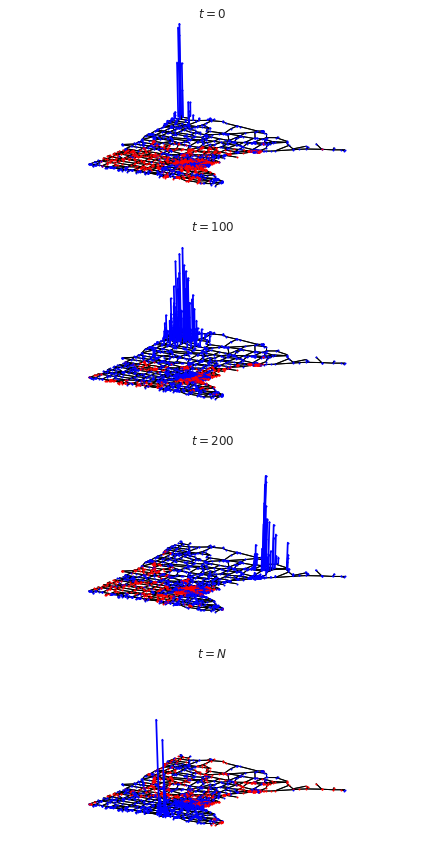

In [12]:
fig = plt.figure(figsize=(6,12))

lc = collections.LineCollection(lines, linewidths=1, colors='k')
ax0 = fig.add_subplot(4, 1, 1, projection='3d')
graph3d(xy[:,0], xy[:,1], g_t[0], fig=fig, ax=ax0, lc=lc)
ax0.set_title(r'$t=0$')

lc = collections.LineCollection(lines, linewidths=1, colors='k')
ax1 = fig.add_subplot(4, 1, 2, projection='3d')
graph3d(xy[:,0], xy[:,1], g_t[100], fig=fig, ax=ax1, lc=lc)
ax1.set_title(r'$t=100$')

lc = collections.LineCollection(lines, linewidths=1, colors='k')
ax2 = fig.add_subplot(4, 1, 3, projection='3d')
graph3d(xy[:,0], xy[:,1], g_t[200], fig=fig, ax=ax2, lc=lc)
ax2.set_title(r'$t=200$')

lc = collections.LineCollection(lines, linewidths=1, colors='k')
ax3 = fig.add_subplot(4, 1, 4, projection='3d')
graph3d(xy[:,0], xy[:,1], g_t[-1], fig=fig, ax=ax3, lc=lc)
ax3.set_title(r'$t=N$')

plt.tight_layout()

# Filtering and convolution

Using some transfer function $\hat{h}$, we can filter an input signal as follows:

#### Classical frequency filtering
\begin{equation}
      f_{out}(t) = \mathcal{F}^{-1} \{ \hat{f}_{in}(\xi) \hat{h}(\xi)\}
\end{equation}

In the graph setting:
  
#### Graph filtering in the graph spectral domain
\begin{equation}
      \begin{split}
        \hat{h}(L) = U
        \begin{bmatrix}
          \hat{h}(\lambda_0) & & 0 \\
           & \ddots & \\
          0 & & \hat{h}(\lambda_{N-1})
        \end{bmatrix}
        U^*
      \\\\
      f_{out} = \hat{h}(L) f_{in}
      \end{split}
    \end{equation}

## Gaussian filter

In [13]:
def gaussian_filter(f, std=1):
    return np.exp(-(f**2 / (2*std**2)))

In [14]:
hhat = u @ np.diag(gaussian_filter(l, std=0.2)) @ u.T

In [15]:
gnoisy = 4*g_t[150] + 0.03*np.random.randn(len(g))

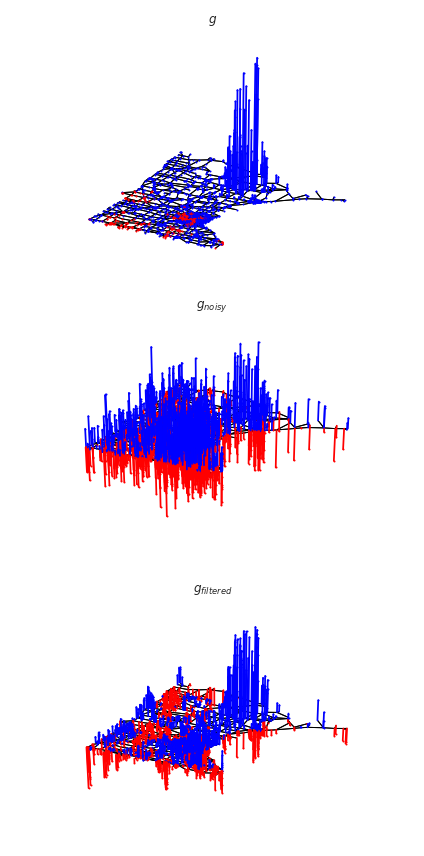

In [16]:
fig = plt.figure(figsize=(6,12))

lc = collections.LineCollection(lines, linewidths=1, colors='k')
ax0 = fig.add_subplot(3, 1, 1, projection='3d')
graph3d(xy[:,0], xy[:,1], g_t[150], fig=fig, ax=ax0, lc=lc)
ax0.set_title(r'$g$')

lc = collections.LineCollection(lines, linewidths=1, colors='k')
ax1 = fig.add_subplot(3, 1, 2, projection='3d')
graph3d(xy[:,0], xy[:,1], gnoisy, fig=fig, ax=ax1, lc=lc)
ax1.set_title(r'$g_{noisy}$')

lc = collections.LineCollection(lines, linewidths=1, colors='k')
ax2 = fig.add_subplot(3, 1, 3, projection='3d')
graph3d(xy[:,0], xy[:,1], hhat @ gnoisy, fig=fig, ax=ax2, lc=lc)
ax2.set_title(r'$g_{filtered}$')

plt.tight_layout()

## Remove high-frequency eigenvalues

In [17]:
hhat = u @ np.diag(np.where(l < l[100], l, 0)) @ u.T

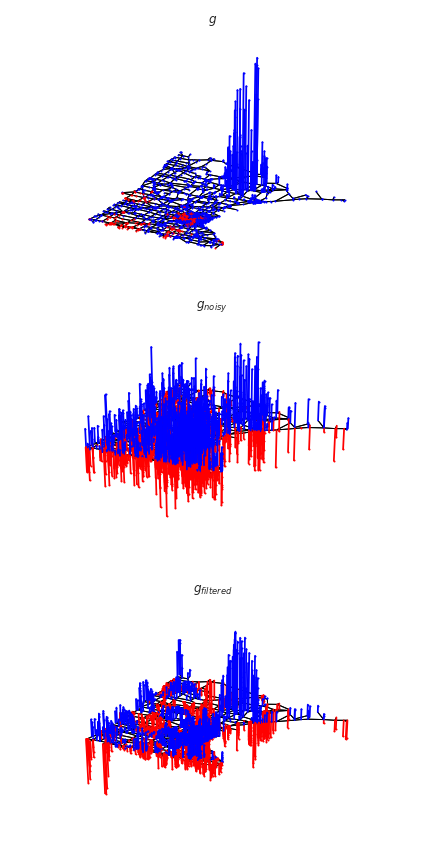

In [18]:
fig = plt.figure(figsize=(6,12))

lc = collections.LineCollection(lines, linewidths=1, colors='k')
ax0 = fig.add_subplot(3, 1, 1, projection='3d')
graph3d(xy[:,0], xy[:,1], g_t[150], fig=fig, ax=ax0, lc=lc)
ax0.set_title(r'$g$')

lc = collections.LineCollection(lines, linewidths=1, colors='k')
ax1 = fig.add_subplot(3, 1, 2, projection='3d')
graph3d(xy[:,0], xy[:,1], gnoisy, fig=fig, ax=ax1, lc=lc)
ax1.set_title(r'$g_{noisy}$')

lc = collections.LineCollection(lines, linewidths=1, colors='k')
ax2 = fig.add_subplot(3, 1, 3, projection='3d')
graph3d(xy[:,0], xy[:,1], hhat @ gnoisy, fig=fig, ax=ax2, lc=lc)
ax2.set_title(r'$g_{filtered}$')

plt.tight_layout()

# Modulation

In simple terms, modulation is like a "translation" in the frequency domain.
  
#### Classical modulation
\begin{equation}
  \begin{split}
        \text{Time domain: } (M_\omega f)(t) = e^{2 \pi j \omega t} f(t) \\
        \text{Frequency domain: } \overline{M_\omega f}(\xi) = \hat{f}(\xi -
        \omega)
  \end{split}
\end{equation}

Replace complex exponential with a graph Laplacian eigenvector:
  
#### Graph modulation
\begin{equation}
  (M_kf)(i) = \sqrt{N} u_k(i) f(i)
\end{equation}

If a kernel $f$ is localized around 0 in the graph spectral domain, then
$\overline{M_kg}$ is localized around $\lambda_k$.

In [19]:
g = g_t[150]
N = Aroads.shape[0]

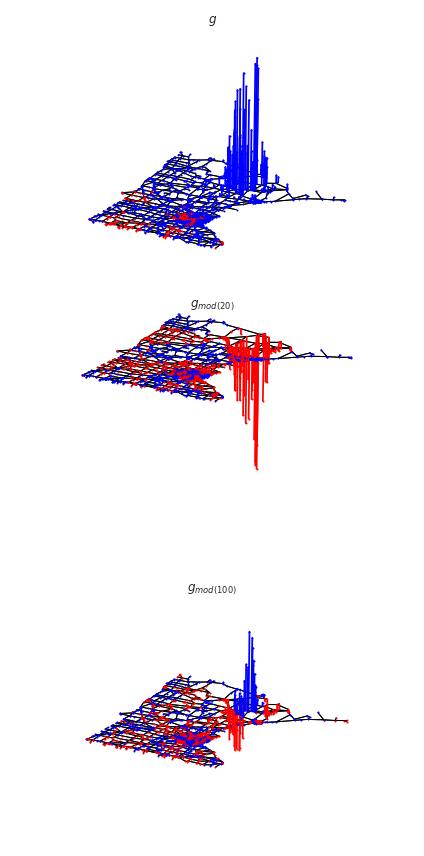

In [20]:
fig = plt.figure(figsize=(6,12))

lc = collections.LineCollection(lines, linewidths=1, colors='k')
ax0 = fig.add_subplot(3, 1, 1, projection='3d')
graph3d(xy[:,0], xy[:,1], g, fig=fig, ax=ax0, lc=lc)
ax0.set_title(r'$g$')

lc = collections.LineCollection(lines, linewidths=1, colors='k')
ax1 = fig.add_subplot(3, 1, 2, projection='3d')
graph3d(xy[:,0], xy[:,1], np.sqrt(N) * u[:, 20] * g, fig=fig, ax=ax1, lc=lc)
ax1.set_title(r'$g_{mod(20)}$')

lc = collections.LineCollection(lines, linewidths=1, colors='k')
ax2 = fig.add_subplot(3, 1, 3, projection='3d')
graph3d(xy[:,0], xy[:,1], np.sqrt(N) * u[:, 100] * g, fig=fig, ax=ax2, lc=lc)
ax2.set_title(r'$g_{mod(100)}$')

plt.tight_layout()

# Dilation

#### Classical dilation

\begin{equation}
  \begin{split}
        \text{Time domain: } (D_s f)(t) = \frac{1}{s} f \bigg( \frac{t}{s} \bigg) \\
        \text{Frequency domain: } \overline{D_s f}(\xi) = \hat{f}(s \xi)
  \end{split}
\end{equation}

Replace the frequency $\xi$ with an eigenvalue of the Laplacian.
  
#### Graph dilation

\begin{equation}
      (D_sf)(\lambda) = \hat{f} (s \lambda)
\end{equation}

In [27]:
Lroads = Lroads.tocsc()
E = linalg.expm(-np.asarray(Lroads.todense()))

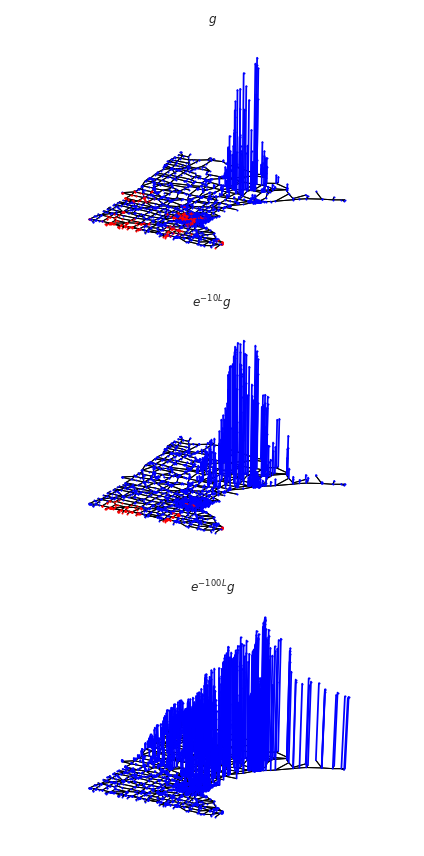

In [33]:
fig = plt.figure(figsize=(6,12))

lc = collections.LineCollection(lines, linewidths=1, colors='k')
ax0 = fig.add_subplot(3, 1, 1, projection='3d')
graph3d(xy[:,0], xy[:,1], g, fig=fig, ax=ax0, lc=lc, vmin=0, vmax=g.max())
ax0.set_title(r'$g$')

lc = collections.LineCollection(lines, linewidths=1, colors='k')
ax1 = fig.add_subplot(3, 1, 2, projection='3d')
graph3d(xy[:,0], xy[:,1], np.linalg.matrix_power(E, 10) @ g, fig=fig, ax=ax1, lc=lc,
       vmin=0, vmax=g.max())
ax1.set_title(r'$e^{- 10 L} g$')

lc = collections.LineCollection(lines, linewidths=1, colors='k')
ax2 = fig.add_subplot(3, 1, 3, projection='3d')
graph3d(xy[:,0], xy[:,1], np.linalg.matrix_power(E, 100) @ g, fig=fig, ax=ax2, lc=lc,
       vmin=0, vmax=g.max())
ax2.set_title(r'$e^{- 100 L} g$')

plt.tight_layout()